# Project: Behavioral Cloning
The goal of this project is to use colected simulation data to generate a model which would in turn generate steering angle data to be used on the simulator, based on image input.

The simulation dataset used for the following model was the one provided by Udacity at the following [link](https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip).

### Rubric: Required Files
 - **Criteria**: Are all required files submitted?
 - **Acceptance criteria**: The submission includes a model.py file, drive.py, model.h5 a writeup report and video.mp4.
 - **Output**: **PASS** 

> **HMA**: Please find the required files at the same directory in this repository.
- model.py (This file)
- [model.h5](https://github.com/hmaleman/course-udacity-selfDrivingCarND/blob/master/term1-computerVision-DeepLearning/09-proj-behavioralCloning/model.h5)
- [drive.py](https://github.com/hmaleman/course-udacity-selfDrivingCarND/blob/master/term1-computerVision-DeepLearning/09-proj-behavioralCloning/drive.py)
- [video.mp4](https://github.com/hmaleman/course-udacity-selfDrivingCarND/blob/master/term1-computerVision-DeepLearning/09-proj-behavioralCloning/video.mp4)


## Download data
In order to work locally and remotly, the simulation dataset download and unpack process was automated as presented below. 

In [1]:
# HMA: Data download 
# Check / Download / Unzip - Dataset

import os
simulationData_DIR = './00-proj-simulationDataUdacity'
simulationData_ZIP = './00-proj-simulationDataUdacity.zip'

if not(os.path.isdir(simulationData_DIR)):
    if not(os.path.exists(simulationData_ZIP)):
        # Download Dataset zipfile if DIR and ZIP file do not exist
        import urllib.request
        url = 'https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip'
        print("Downloading Simulation Data...")
        urllib.request.urlretrieve(url, simulationData_ZIP)
    
    # Unzip Dataset zipfile
    if (os.path.exists(simulationData_ZIP)):
        print("Unzipping Simulation Data...")
        os.makedirs(simulationData_DIR)
        import zipfile
        zip_ref = zipfile.ZipFile(simulationData_ZIP, 'r')
        zip_ref.extractall(simulationData_DIR)
        zip_ref.close()
print("Dataset ready.")

Dataset ready.


### Rubric: Architecture and Training Documentation
 - **Criteria**: Is the creation of the training dataset and training process documented?
 - **Acceptance criteria**: The README describes how the model was trained and what the characteristics of the dataset are. Information such as how the dataset was generated and examples of images from the dataset must be included.
 - **Output**: **PASS** 

> **HMA**: The dataset used was only the one provided by Udacity. It contained two recorded laps of the car running on the opposide sense of the Track in which the model would later be tested. Image analysis were done at the [version 1](https://github.com/hmaleman/course-udacity-selfDrivingCarND/blob/master/term1-computerVision-DeepLearning/09-proj-behavioralCloning/01-proj-behavioralCloning.ipynb), but since the use of Generator, images were no longer extracted. 

## Import data
The step "Import data" initially loaded all simulation images which were used at the Training step. However, not only as required by the project rubrics, but also necessary to allow bigger training sets, this step only prepares the internal variables which were then later used by the Generator to import the images.

The simulation dataset was composed by a driving_log csv file and a directory with recorded images.

A drive log entry contained the paths for the 3 images (center, left and right mounted cameras) and the associated steering angle, throtle and brake values when the image was captured. 

The code below simply parses the driving log for later processing.

In [2]:
# Read log file
# [0] center image
# [1] left image
# [2] right image
# [3] steering angle

import csv

log_DIR = os.path.join(simulationData_DIR, 'data')
log_FILE = 'driving_log.csv'
driving_log = []
with open(os.path.join(log_DIR, log_FILE)) as csvfile:
    reader = csv.reader(csvfile, escapechar=' ')
    for line in reader:
        driving_log.append(line)

driving_log = driving_log[1:] # crop CSV titles
pass

## Data augmentation
As mentioned above, the image importing is only done at the Generator, in this step only a preparation for data augmentation was done.

For the Udacity simulation dataset, a few techniques were used to augment the data:
- Use captured images from the left camera with steering angle minus a delta parameter as example situation to return to the lane center
- Use captured images from the right camera with steering angle plux a delta parameter as example image to return to the lane center
- Flip the center, right and left camera images and the associated steering angles.

After a few tests (0.10, 0.20 and 0.30), the model behaved better with a delta angle correction of 0.25

In [3]:
import cv2

img_DIR = log_DIR
centerCamImageIndex = 0
leftCamImageIndex   = 1
rightCamImageIndex  = 2
steeringAngleIndex  = 3

logSet = []
deltaAngle = 0.25
for log_entry in driving_log:
    img_FILE = log_entry[centerCamImageIndex]
    angle = float(log_entry[steeringAngleIndex])
    logSet.append([img_FILE, angle, False])
    logSet.append([img_FILE, -angle, True])
    
    img_FILE = log_entry[leftCamImageIndex]
    angle = float(log_entry[steeringAngleIndex]) + deltaAngle
    logSet.append([img_FILE, angle, False])
    logSet.append([img_FILE, -angle, True])
    
    img_FILE = log_entry[rightCamImageIndex]
    angle = float(log_entry[steeringAngleIndex]) - deltaAngle
    logSet.append([img_FILE, angle, False])
    logSet.append([img_FILE, -angle, True])

### Rubric: Quality of Code
 - **Criteria**: Is the code usable and readable?
 - **Acceptance criteria**: The code in model.py uses a Python generator, if needed, to generate data for training rather than storing the training data in memory. The model.py code is clearly organized and comments are included where needed.
 - **Output**: **PASS** 

> **HMA**: A Generator was used for this project, since the amount of input data exceeded the available memory. Please find below futher details about the Generator.

## Generator
The section below presents the data Generator. It uses the previously loaded information from images paths and steering angles to load the images and provide it the to training routine on-the-fly. 

After the use of Data Augmentation, it was required to introduce this technique, and the [version 1](https://github.com/hmaleman/course-udacity-selfDrivingCarND/blob/master/term1-computerVision-DeepLearning/09-proj-behavioralCloning/01-proj-behavioralCloning.ipynb) was stopped. The first datasets using only a first step of Data Augmentation with the side cameras, had the AWS instance operating with over 53%. Adding the flipped images exceeded the available memor  

In [4]:
import sklearn
import cv2
import numpy as np

imgIndex = 0
angleIndex = 1
flipIndex = 2

def generator(samples, batch_size=32):
    while 1:
        for offset in range(0, len(samples), batch_size):
            batch_samples = samples[offset:offset + batch_size]
            imgSet = []   # Placeholder for the input images
            angleSet = [] # Placeholder for the associated label (or value, in this regression problem)
            for log_entry in batch_samples:
                img_FILE = log_entry[imgIndex]
                img = cv2.imread(os.path.join(img_DIR, img_FILE))
                if log_entry[flipIndex] == True:
                    img = cv2.flip(img, 1)
                imgSet.append(img)
                angleSet.append(log_entry[angleIndex])

            X_train = np.array(imgSet)
            y_train = np.array(angleSet)
            yield sklearn.utils.shuffle(X_train, y_train)


In order to avoid interference due to image sequence, the loaded dataset is shuffled.

In [ ]:
sklearn.utils.shuffle(logSet)
pass

### Rubric: Model Architecture and Training Strategy
 - **Criteria**: Has an attempt been made to reduce overfitting of the model?
 - **Acceptance criteria**: Train/validation/test splits have been used, and the model uses dropout layers or other methods to reduce overfitting.
 - **Output**: **PASS** 

> **HMA**: For details about the data split, please check the section below. Overfitting was monitored through the check of validation_loss at the training output. Furthermore the used training set from Udacity was recorded running on the other sense that the generated model would run on the track. 

>This situation already help to prevent overfit, since the model would run on a "different" track than the one trained. In other words, a successful autonomous run indicates a good model generalization.

## Data split - Training and Validation sets
The loaded simulation dataset is split in Training and Validation sets with a ratio of 80/20.

In [6]:
from sklearn.model_selection import train_test_split

logSet_train, logSet_valid = sklearn.model_selection.train_test_split(logSet, test_size=0.2)

With the Training and Validation tests available, it's possible to define a Generator object for each of them.

In [7]:
train_generator = generator(logSet_train, batch_size=32)
validation_generator = generator(logSet_valid, batch_size=32)

### Rubric: Model Architecture and Training Strategy 
- **Criteria**: Has an appropriate model architecture been employed for the task?
- **Acceptance criteria**: The neural network uses convolution layers with appropriate filter sizes. Layers exist to introduce nonlinearity into the model. The data is normalized in the model.
- **Output**: **PASS** 


- **Criteria**: Have the model parameters been tuned appropriately?
- **Acceptance criteria**: Learning rate parameters are chosen with explanation, or an Adam optimizer is used. 
- **Output**: **PASS** 

> **HMA**: Please find below the details about the chosen architecture, applied layers, learning rate and optimizer.

### Rubric: Architecture and Training Documentation
 - **Criteria**: Is the solution design documented?
 - **Acceptance criteria**: The README thoroughly discusses the approach taken for deriving and designing a model architecture fit for solving the given problem.
 - **Output**: **PASS** 


 - **Criteria**: Is the model architecture documented?
 - **Acceptance criteria**: The README provides sufficient details of the characteristics and qualities of the architecture, such as the type of model used, the number of layers, the size of each layer. Visualizations emphasizing particular qualities of the architecture are encouraged.
 - **Output**: **PASS** 

> **HMA**: Please find below further explation on the applied architecutre.

## Model definition and training
The model selected for this project was the one developed by NVIDIA at the papper: https://arxiv.org/abs/1604.07316 

This architecture presented for End to End Learning for self-driving cars just fits to the project's goal. It was built to map raw pixels from front-facing cameras to predict steering angle commands and had the following architectural construction:

<img src="10-auxPic-nvidiaCnn.png" alt="CNN architecture" style="width:300px;"/>

**Architecture observations:**
- The input layer applies a normalization of x / 255.0 - 0.5
- A image crop layer follows reducing the input from 320x160 to 320x65
- As non linearity, a ReLU activation was used for every convolutional layer.
- A stride of 2x2 was used on the first 3 layers. 
- The implemented model below does not contain the 1164 neuron Dense layer. This  of this layer led to a lighter and faster model to train with satisfactory performance.
- Adam optimizer with the standard learning rate of 0.001 was enough to achieve a small validation loss.

In [8]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Convolution2D
from keras.callbacks import ModelCheckpoint
model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25), (0,0))))
model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

checkpoint = ModelCheckpoint('model.{epoch:02d}-{val_loss:.4f}.h5', 
                             monitor='val_loss', 
                             verbose=0, 
                             save_best_only=False, 
                             save_weights_only=False, 
                             period=1)

history_object = model.fit_generator(train_generator, 
                                     samples_per_epoch=len(logSet_train), 
                                     validation_data=validation_generator,
                                     nb_val_samples=len(logSet_valid), 
                                     nb_epoch=5, 
                                     verbose=2,
                                     callbacks=[checkpoint])
model.save('model.h5')

Using TensorFlow backend.


Epoch 1/5
83s - loss: 0.0233 - val_loss: 0.0207
Epoch 2/5
81s - loss: 0.0199 - val_loss: 0.0192
Epoch 3/5
78s - loss: 0.0183 - val_loss: 0.0189
Epoch 4/5
79s - loss: 0.0169 - val_loss: 0.0185
Epoch 5/5
80s - loss: 0.0157 - val_loss: 0.0188


As showed above and on the graph below, a number of 5 epochs is on the limit between model improvement and overfitting, since the validation_loss stabilizes at between epoch 4 and 5. 

dict_keys(['loss', 'val_loss'])


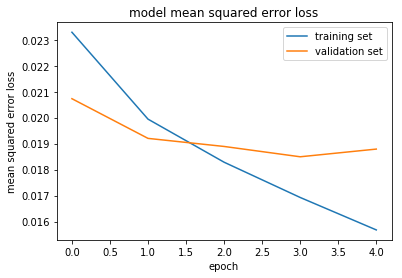

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

### Rubric: Simulation
 - **Criteria**: Is the car able to navigate correctly on test data?
 - **Acceptance criteria**: No tire may leave the drivable portion of the track surface. The car may not pop up onto ledges or roll over any surfaces that would otherwise be considered unsafe (if humans were in the vehicle).
 - **Output**: **PASS** 

> **HMA**: Please find below the notes on the simulaton run.

## Conclusion
The generated model drives well throughout all the Track 1, except for a shaddy section after a curve, where it runs over the lane line. Nevertheless, in this situation, the car does not run over the curb, it is still safe.

As presented at the introduction, only the Udacity dataset was used, which prooved a enough to generate a running model. Further data was required to improve the behavior at a specific section from Track 1. However, as detailed at the [model version 3](https://github.com/hmaleman/course-udacity-selfDrivingCarND/blob/master/term1-computerVision-DeepLearning/09-proj-behavioralCloning/03-proj-behavioralCloning-generatorRefined.ipynb), it was not possible to generate good training data using only the keyboard and the output models had worse performance.

The model also performs well on Track 2. The car however is not able to handle a curve too closed and blocks. It would require additinal data to have a model handle the new situation.

### Rubric: Quality of Code
 - **Requirement**: Is the code functional?
 - **Acceptance criteria**: The model provided can be used to successfully operate the simulation. 
 - **Output**: **PASS** 

> **HMA**: The generated code produces a model, with good results as presented at video.mp4.